#### Importing libraries

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

In [3]:
from simulai.metrics import L2Norm
from simulai.optimization import Optimizer
from simulai.regression import DenseNetwork
from simulai.residuals import SymbolicOperator

c:\Users\JVAZQ150\Documents\jvazq150_local\Github Repositories\PIML\venv\lib\site-packages\simulai\regression\_opinf.py:33: UserWarning: Trying to import MPI in c:\Users\JVAZQ150\Documents\jvazq150_local\Github Repositories\PIML\venv\lib\site-packages\simulai\regression\_opinf.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
c:\Users\JVAZQ150\Documents\jvazq150_local\Github Repositories\PIML\venv\lib\site-packages\simulai\regression\_opinf.py:34: UserWarning: mpi4py is not installed. If you want to execute MPI jobs, we recommend you install it.
  warnings.warn(
c:\Users\JVAZQ150\Documents\jvazq150_local\Github Repositories\PIML\venv\lib\site-packages\simulai\parallel.py:24: UserWarning: Trying to import MPI in c:\Users\JVAZQ150\Documents\jvazq150_local\Github Repositories\PIML\venv\lib\site-packages\simulai\parallel.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
c:\Users\JVAZQ150\Documents\jvazq150_local\Github Repositories\PIML\venv\lib\site-packages\simulai\pa

#### Parameters setup

In [20]:
N = 5_000
n = 1_000
T = 5
T_max = 50

# Constants
m = 1500  # Mass of the vehicle (kg)
#rho = 1.2  # Air density (kg/m^3)
P = 101325  #Standard atmospheric pressure in Pascal
R = 287  #Specific gas constant for dry air (J/(kg·K))
A = 2.5   # Frontal area of the vehicle (m^2)
Cd = 0.3 # Drag coefficient
temp_linspace = np.linspace(-40, 40, 20)

#### Time domains

In [17]:
time_train = (np.random.rand(n) * T_max)[:, None]
time_eval = np.linspace(0, T_max, N)[:, None]

Braking dynamics of a vehicle
$$
m\frac{dv}{dt} = - F_{brake}(T) - \frac{1}{2}\rho(T) A C_d v^2
$$
or
$$
m\frac{dv}{dt} + F_{brake}(T) + \frac{1}{2}\rho(T) A C_d v^2 = 0
$$

where $F_{brake}(T)$ reprensents that the braking force is temperature dependent. In our study case, we considere de following relationship. 

<div style="margin-left: auto; margin-right: auto;">
    <table style="margin-left: auto; margin-right: auto; text-align: center">
        <tr>
            <th>Temperature (°C)</th>
            <th>Brake Force</th>
        </tr>
        <tr>
            <td>-40</td>
            <td>2000</td>
        </tr>
        <tr>
            <td>-30</td>
            <td>2100</td>
        </tr>
        <tr>
            <td>-20</td>
            <td>2200</td>
        </tr>
        <tr>
            <td>-10</td>
            <td>2300</td>
        </tr>
        <tr>
            <td>0</td>
            <td>2400</td>
        </tr>
        <tr>
            <td>10</td>
            <td>2450</td>
        </tr>
        <tr>
            <td>20</td>
            <td>2500</td>
        </tr>
        <tr>
            <td>30</td>
            <td>1500</td>
        </tr>
        <tr>
            <td>40</td>
            <td>1000</td>
        </tr>
    </table>
</div>

On the other hand, the air density $\rho(T) = \frac{P}{R*T_{kelvin}}$ is also temperature dependent.

This model is a fundamental part of vehicle dynamics, particularly in safety analysis and design, to ensure that vehicles can effectively come to a stop under various conditions and speeds. It is widely used in both theoretical studies and practical applications like driver assistance systems and autonomous vehicle algorithms.








In [50]:
f = "m * D(v, t) + brake_force + 0.5*rho*A*Cd*(v^2)"

In [51]:
input_labels = ["t"]
output_labels = ["v"]
n_inputs = len(input_labels)
n_outputs = len(output_labels)
n_epochs = 15_000
lr = 1e-3

In [52]:
def model():

    from simulai.models import ImprovedDenseNetwork
    from simulai.regression import SLFNN, ConvexDenseNetwork

    # Configuration for the fully-connected network
    config = {
        "layers_units": [100, 100, 100],
        "activations": "tanh",
        "input_size": 1,
        "output_size": 1,
        "name": "net",
    }

    # Instantiating and training the surrogate model
    densenet = ConvexDenseNetwork(**config)
    encoder_u = SLFNN(input_size=1, output_size=100, activation="tanh")
    encoder_v = SLFNN(input_size=1, output_size=100, activation="tanh")

    net = ImprovedDenseNetwork(
        network=densenet,
        encoder_u=encoder_u,
        encoder_v=encoder_v,
        devices="gpu",
    )

    return net

In [53]:
optimizer_config = {"lr": lr}
optimizer = Optimizer("adam", params=optimizer_config)

Optimizer adam found in torch.optim.


In [54]:
# Given polynomial coefficients
coefficients = [
        1.0138888888888934e-06,
        1.6506410256410225e-05,
        -0.0024236111111111164,
        -0.04659819347319338,
        0.7458585858585867,
        19.663752913752855,
        2357.5757575757566
]
# Given data points for temperature
T_Celsius_points = np.array([-40, -30, -20, -10, 0, 10, 20, 30, 40])
# Constructing the variable T_Celsius_smooth
T_Celsius_smooth = np.linspace(T_Celsius_points.min(), T_Celsius_points.max(), 500)

In [55]:
simul_results = []
for i, temp in enumerate(temp_linspace):
  print("Iteration", i)
  # Temperature dependet variables
  T_Kelvin = temp + 273.15  # Convert temperature to Kelvin
  rho = P / (R * T_Kelvin) # Air_density
  # Evaluating the polynomial at T_Celsius_smooth
  brake_force = np.polyval(coefficients, temp)
  # Set residual
  net = model()
  residual = SymbolicOperator(
    expressions=[f],
    input_vars=["t"],
    output_vars=["v"],
    constants = {'m':m, 'brake_force':brake_force, 'rho':rho, 'A':A, 'Cd':Cd},
    function=net,
    engine="torch",
    device="gpu",)
  # Set params
  params = {
    "residual": residual,
    "initial_input": np.array([1])[:, None],
    "initial_state": np.array([100]),
    "weights_residual": [1],
    "initial_penalty": 1,}
  # Fitting PINN
  optimizer.fit(
    op=net,
    input_data=time_train,
    n_epochs=n_epochs,
    loss="pirmse",
    params=params,
    device="gpu",
    )
  time_eval = np.linspace(0, 50, N)[:, None]
  approximated_data = net.eval(input_data=time_eval)
  simul_results.append(approximated_data)

Iteration 0
pde:5189661.5 init:9631.427734375 

pde:65.44972229003906 init:0.024578848853707314   Iteration 1
pde:2.9678449630737305 init:0.030858827754855156 Iteration 2
pde:2.231863260269165 init:0.14358150959014893   Iteration 3
pde:274.28216552734375 init:0.058739811182022095 Iteration 4
pde:25.96352195739746 init:0.11192810535430908  Iteration 5
pde:14.228851318359375 init:0.15177834033966064 Iteration 6
pde:20.59937286376953 init:0.01834525167942047 2  Iteration 7
pde:91.544921875 init:0.035676002502441406 759   Iteration 8
pde:21.108440399169922 init:0.083336740732193   Iteration 9
pde:246.78936767578125 init:0.12770676612854004  Iteration 10
pde:29.735109329223633 init:0.07176554948091507  Iteration 11
pde:10.042093276977539 init:0.04600716009736061  Iteration 12
pde:33.50517654418945 init:0.3917416036128998   Iteration 13
pde:109.66345977783203 init:0.5091054439544678  Iteration 14
pde:12.564423561096191 init:0.046085745096206665 Iteration 15
pde:131.6211700439453 init:0.07669120281934738   Iteration 16
pde:22.3353672027587

In [56]:
len(simul_results)
simul_results_list = []
for result in simul_results:
  simul_results_list.append(np.where(result < 0, 0, result))
print(simul_results_list[0].shape)
print(time_eval.shape)

(5000, 1)
(5000, 1)


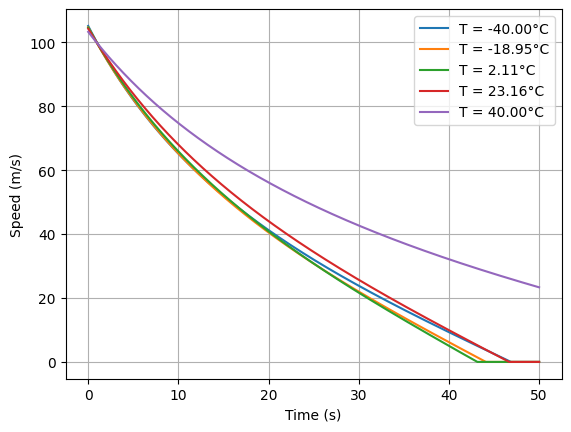

<Figure size 640x480 with 0 Axes>

In [79]:
# Plotting results
for ii in range(n_outputs):
    plt.plot(time_eval, simul_results_list[0], label=f"T = {temp_linspace[0]:.2f}°C")
    plt.plot(time_eval, simul_results_list[5], label = f"T = {temp_linspace[5]:.2f}°C")
    plt.plot(time_eval, simul_results_list[10], label=f"T = {temp_linspace[10]:.2f}°C")
    plt.plot(time_eval, simul_results_list[15], label=f"T = {temp_linspace[15]:.2f}°C")
    plt.plot(time_eval, simul_results_list[19], label=f"T = {temp_linspace[19]:.2f}°C")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (m/s)")
    plt.legend()
    plt.grid(True)
    plt.show()
plt.tight_layout()
plt.show()

In [58]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


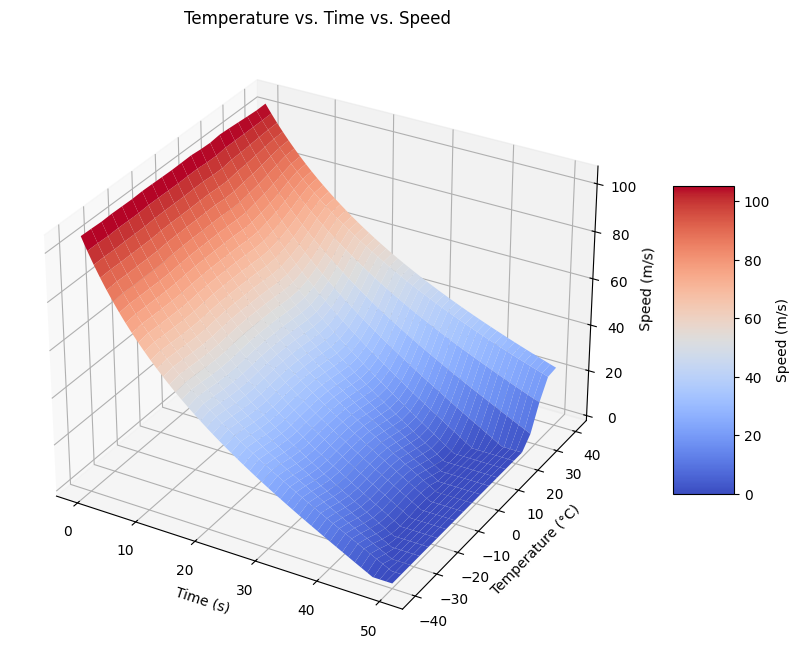

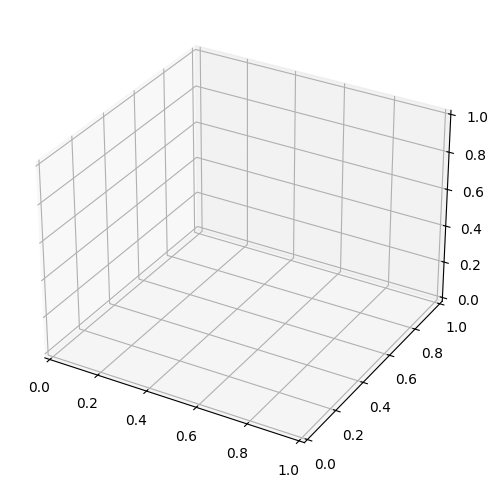

In [87]:
# Convert list of arrays into a 2D numpy array
results = np.array(simul_results_list).reshape(20, 5000)
#scenarios = np.arange(len(simul_results_list))  # Scenario indices
scenarios = temp_linspace
time_np = np.array(time_eval).reshape(5000,)

# Create a meshgrid for plotting
T, S = np.meshgrid(time_np, scenarios)

# Set up the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D surface plot
surface = ax.plot_surface(T, S, results, cmap='coolwarm', edgecolor='none')
#surface = ax.plot_surface(T, S, results, cmap='coolwarm', edgecolor='none')

# Add a color bar which maps values to colors.
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=np.min(results), vmax=np.max(results)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Speed (m/s)')
ax.set_title('Temperature vs. Time vs. Speed')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Speed (m/s)')

# Plotting results
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')





Coefficients of the fitted polynomial:
Degree 6: 1.0138888888888934e-06
Degree 5: 1.6506410256410225e-05
Degree 4: -0.0024236111111111164
Degree 3: -0.04659819347319338
Degree 2: 0.7458585858585867
Degree 1: 19.663752913752855
Degree 0: 2357.5757575757566


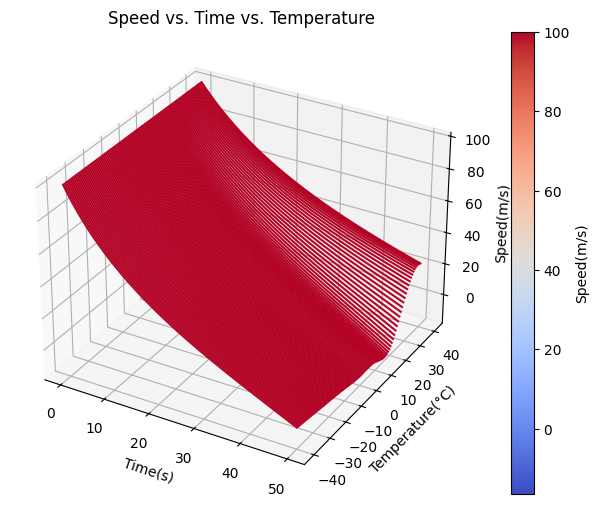

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline


# Constants
m = 1500  #Mass of the vehicle (kg)
P = 101325  #Standard atmospheric pressure in Pascal
R = 287  #Specific gas constant for dry air (J/(kg·K))
A = 2.5  # Frontal area of the vehicle (m^2)
Cd = 0.3  #Drag coefficient

# Given data points for brake force as a function of temperature
T_Celsius_points = np.array([-40, -30, -20, -10, 0, 10, 20, 30, 40])
brake_force_points = np.array([2000, 2100, 2200, 2300, 2400, 2450, 2500, 1500, 1000])

# Perform cubic spline interpolation
spline = CubicSpline(T_Celsius_points, brake_force_points)

# Function to calculate brake force for a given T_Celsius
def brake_force(T_Celsius):
  return spline(T_Celsius)

# Function to calculate air density
def air_density(T_Celsius):
  T_Kelvin = T_Celsius + 273.15  #Convert temperature to Kelvin
  return P / (R * T_Kelvin)

# Function to calculate air drag force
def air_drag(v, rho):
  return 0.5 * rho * A * Cd * v**2

# Function to calculate total longitudinal force
def total_longitudinal_force(v, T_Celsius):
    rho = air_density(T_Celsius)
    return brake_force(T_Celsius)* -1 - air_drag(v,rho)

# Function to calculate acceleration
def acceleration(v, T_Celsius):
    rho = air_density(T_Celsius)
    return total_longitudinal_force(v, T_Celsius) / m

# Time parameters
t0 = 0
tf = 50  # Final time (s)
dt = 0.01  # Time step size

# Initial conditions
v0 = 100  #Initial velocity (m/s)

# Temperature range
temperature_range = np.linspace(-40, 40, 100)  #From -40 to 40 degrees Celsius

# Arrays to store results
speed_data = np.zeros((int(tf/ dt), len(temperature_range)))
time_data = np.zeros((int(tf/ dt), len(temperature_range)))
temperature_data = np.zeros((int(tf/ dt), len(temperature_range)))

# Loop through different temperatures
for idx, T_Celsius in enumerate(temperature_range):
  # Euler's method to solve the differential equation
  v = v0
  for i in range(int(tf/ dt)):
    time = i * dt
    speed_data[i, idx] = v
    time_data[i, idx] = time
    temperature_data[i, idx] = T_Celsius
    a = acceleration(v, T_Celsius)
    v += a * dt
if v < 0:  # Ensure speed doesn't go negative during braking
  v = 0

# Antes de la sección de graficación, modifica la definición de colores para que se base en la velocidad
# Encuentra el valor máximo de velocidad para normalizar los colores
max_speed = np.max(speed_data)
min_speed = np.min(speed_data)  # Esto es nuevo, para definir el rango mínimo de velocidad

# Define colors based on speed values instead of temperature
colors = (speed_data - min_speed) / (max_speed - min_speed)  # Normaliza los valores de velocidad

# Plotting results
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Cambia la asignación de colores en el bucle de graficación para usar los valores de velocidad
for idx, T_Celsius in enumerate(temperature_range):
  ax.plot(time_data[:, idx], temperature_data[:, idx], speed_data[:, idx], color=plt.cm.coolwarm(colors[:,idx][0]))

ax.set_xlabel('Time(s)')
ax.set_ylabel('Temperature(°C)')
ax.set_zlabel('Speed(m/s)')
ax.set_title('Speed vs. Time vs. Temperature')  # Cambia el título para reflejar el enfoque en la velocidad

# Adjust colorbar to reflect speed values
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min_speed, vmax=max_speed))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Speed(m/s)')  # Cambia la etiqueta a velocidad
plt.show()

